# Identification
* **Student Name:** Vi Nguyen
* **Student ID:** 13592629



In [1]:
# Import statements
import numpy as np
import pandas as pd
import apmodule as ap
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10 
plt.rcParams['lines.linewidth'] = 3
%matplotlib inline
from scipy import stats
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [2]:
# user-generate function

In [3]:
# loading of all the files including the 12 facotrs, market caps and prices
a2_factors = pd.read_csv('A2_factors.zip', parse_dates=['date']).set_index(['id', 'date'])
market_cap = pd.read_csv('Market_cap.zip', parse_dates=['date']).set_index(['id', 'date']) 
prices = pd.read_csv('Prices.zip', parse_dates=['date']).set_index(['id', 'date']).squeeze()

In [4]:
# Calculate the future return
future_returns = np.log(prices.groupby('id').shift(-1) / prices).rename('fut_ret')

In [5]:
# combine all the data in a single DataFrame
db = a2_factors.join(future_returns).dropna()
db.head()

gp       fcf      earn      mom1      mom3     mom12  \
id    date                                                                     
10001 2010-01-29 -0.793018 -0.875319  0.083858  0.818616  0.951301 -0.163009   
      2010-02-26 -0.797733 -0.845785  0.058622  0.000814  0.432961 -0.339226   
      2010-03-31 -0.291103 -0.309994  0.901306 -0.309117  0.271293 -0.653354   
      2010-04-30 -0.283234 -0.396078  0.942665 -0.375035 -0.456505 -0.490270   
      2010-05-28 -0.198964  0.599238  0.649458  0.459219 -0.184206 -0.213332   

                       epq      ep12       btm      tvol    n_beta      ivol  \
id    date                                                                     
10001 2010-01-29  0.139442  0.349288 -0.252886  0.760385  1.442764  0.664820   
      2010-02-26  0.132437  0.335893 -0.225393  0.761945  1.438146  0.666264   
      2010-03-31  0.363610  0.350847 -0.025009  0.763834  1.445645  0.667003   
      2010-04-30  0.482144  0.436302 -0.372745  0.761223  1.441098  0.664644   
      2010-05-28  0.530938  0.389566 -0.053542  0.768200  1.451131  0.669388   

                   fut_ret  
id    date                  
10001 2010-01-29 -0.000656  
      2010-02-26  0.020432  
      2010-03-31  0.117237  
      2010-04-30  0.004817  
      2010-05-28 -0.044392

_____________________________________________________________________________________________________________________

# 1. Presentation of Machine Learning Investment

_____________________________________________________________________________________________________________________

# 2. Decision tree

## 2.1 Creating the decision tree

**Step 1: Target Variable**
The tree should try to predict if the next month return will be above or below the median.
- Variable `X` contains all the features (information signals or predictors) and `y` contains the outcome variable.

In [6]:
# The object X contains all the columns of db except the last
X = db.iloc[:,0:-1]

# This is the line if we want returns above the median
y = db['fut_ret'] > db.groupby('date')['fut_ret'].transform('median')

**Step 2: Train-Test Split with time series**
Split the sample along the time dimension:
- Training Sample: From the beginning of 2010 to the end of 2019.
- Test Sample: From the beginning of 2020 to the end of 2022.

In [7]:
X_train = X.loc[pd.IndexSlice[:, '2010-01-01':'2019-12-31'],:]
X_test = X.loc[pd.IndexSlice[:, '2020-01-01':'2022-12-31'],:]

y_train = y.loc[pd.IndexSlice[:, '2010-01-01':'2019-12-31']]
y_test = y.loc[pd.IndexSlice[:, '2020-01-01':'2022-12-31']]

**Step 3: Train Model**
The next steps in our development process will be:
- To load the model class we intend to use (decision tree)
- Instantiate the model with the key parameter of interest (in this case the maximum depth)
- Train the model

In [8]:

# We instantiate the tree and specify the depth parameter of 4
clf = tree.DecisionTreeClassifier(max_depth=4)

# We fit the model using the training data
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

**Step 4:Analyzing the model - Plot the tree**

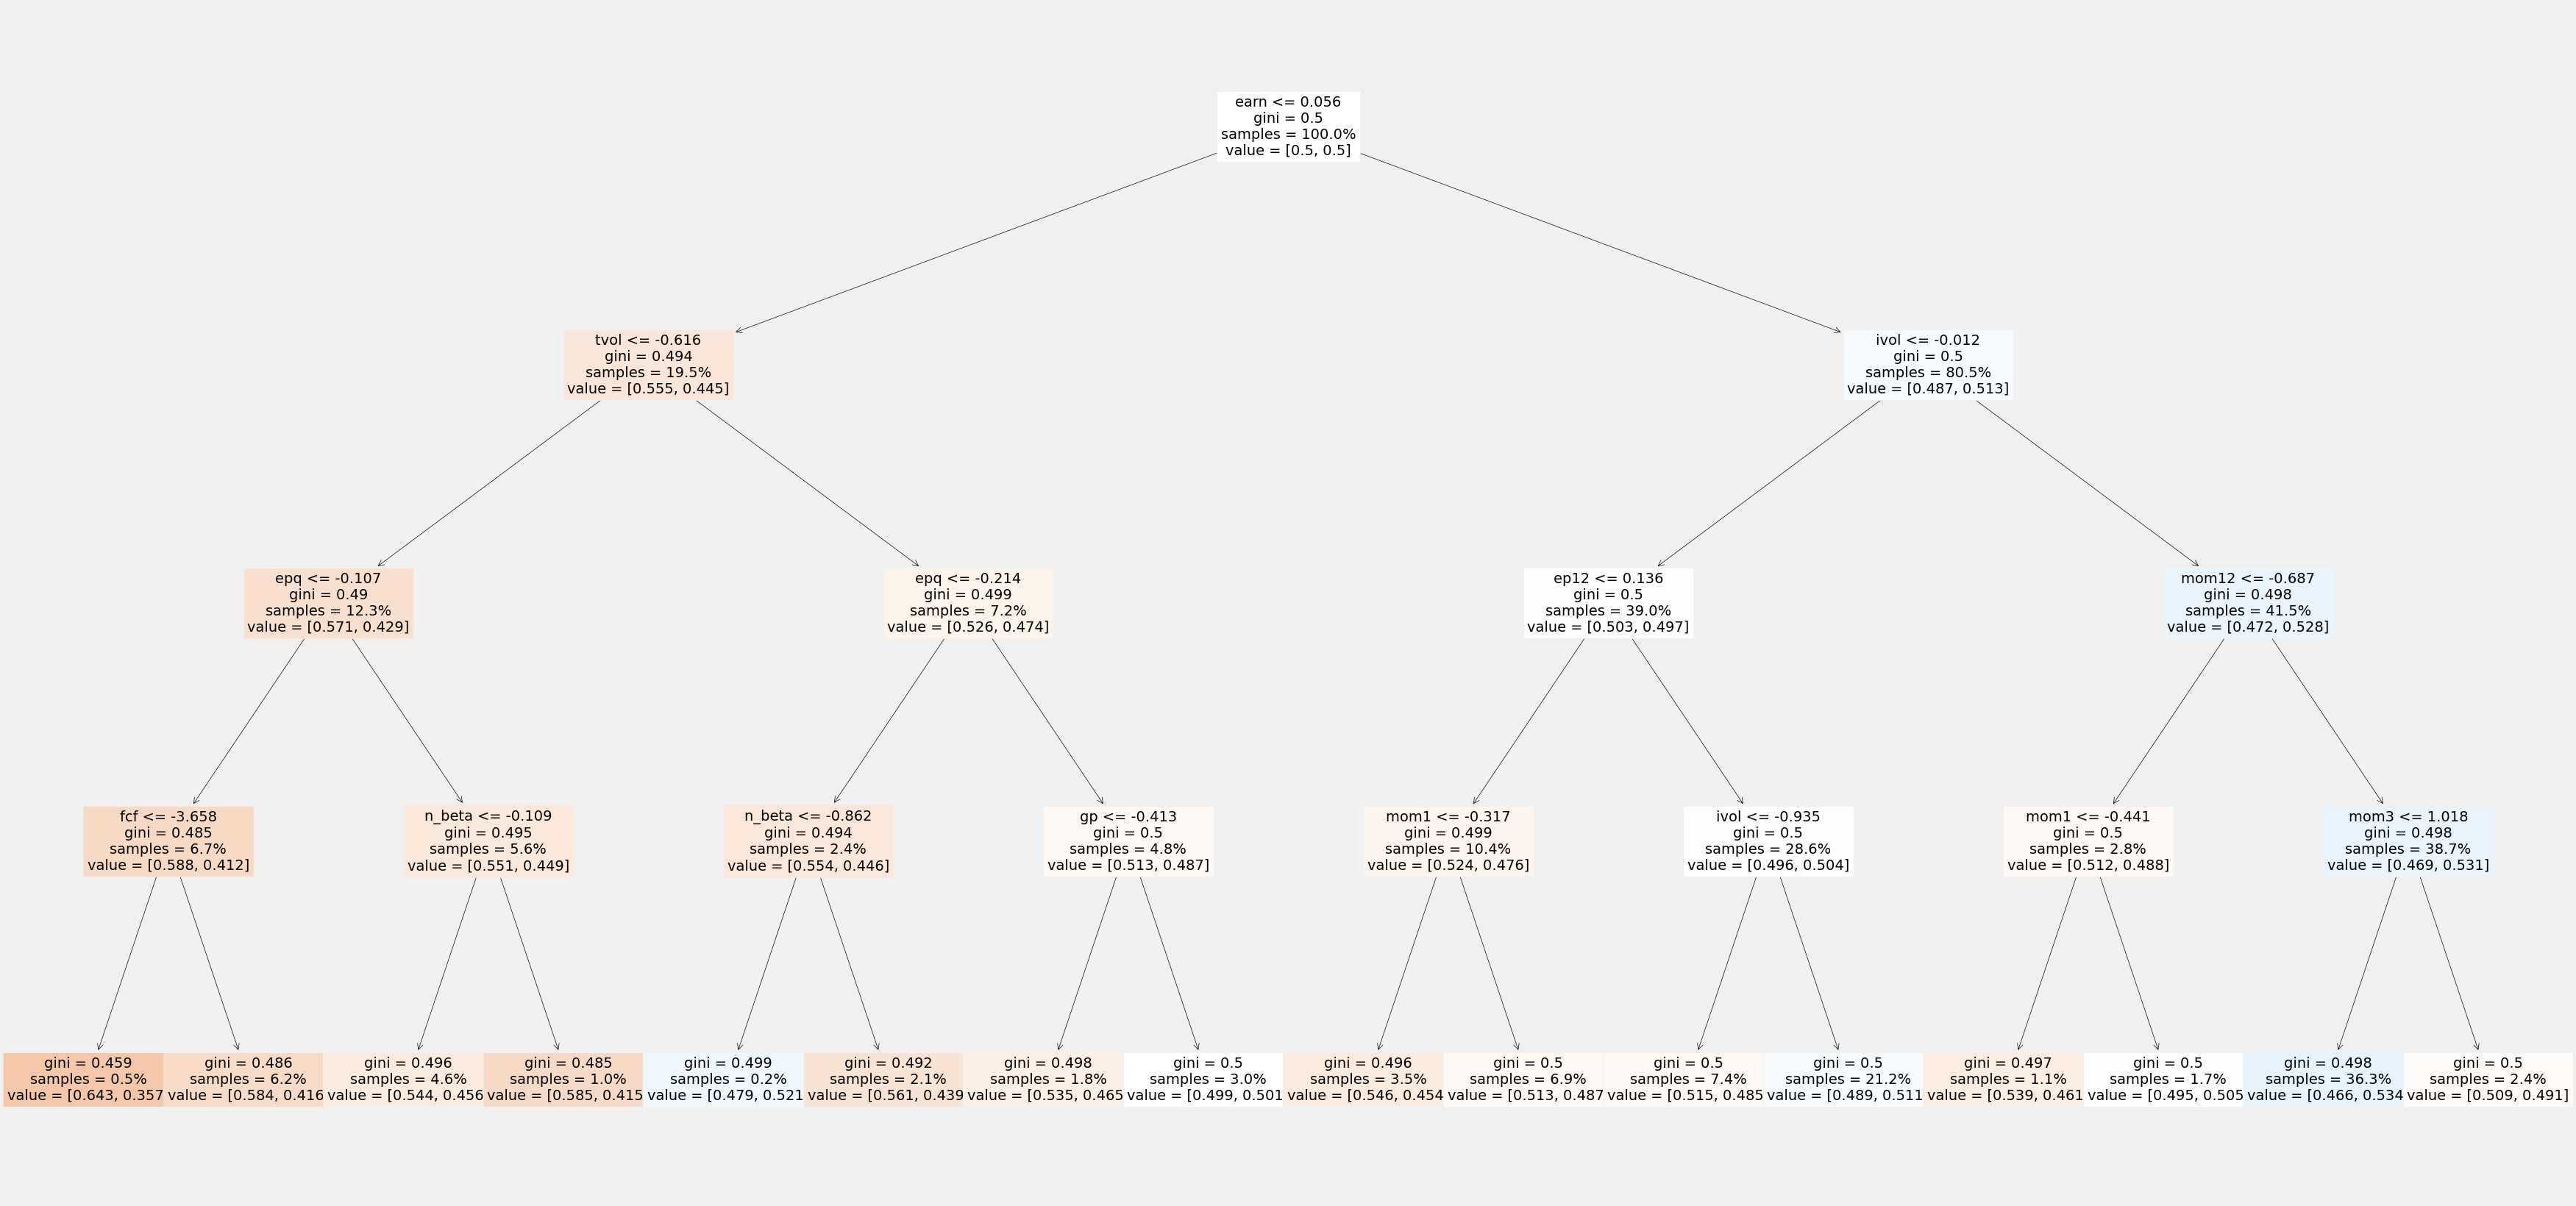

In [9]:
plt.figure(figsize=(40,20))
tree.plot_tree(clf, fontsize=14, feature_names = X.columns, filled=True, proportion=True)
plt.savefig('decision_tree_1.png')

### Feature Importance

Another way to gain valuable insight from the model is to examine the feature importance. This quantity measures the contribution of each information signal to the total reduction of the Gini Impurity achieved by the model.

In [10]:
features = pd.DataFrame(clf.feature_importances_, columns=['Feature Importance'], index=X.columns)
features

,Feature Importance
gp,0.010515
fcf,0.011645
earn,0.526871
mom1,0.028178
mom3,0.031417
mom12,0.036121
epq,0.049442
ep12,0.044030
btm,0.000000
tvol,0.068012


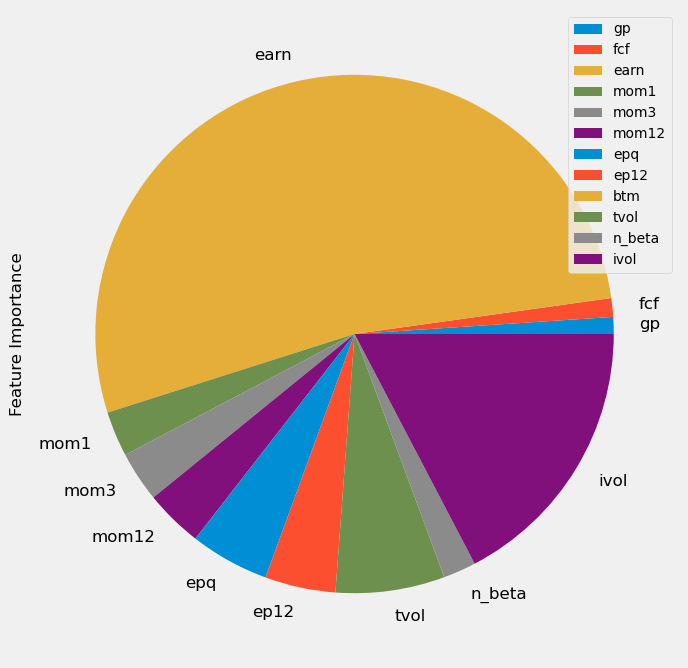

In [11]:
# We can even plot it if we want
features.plot(kind='pie', 
              y='Feature Importance',
              figsize=(10,8),
              fontsize=12)
plt.savefig('Feature importance.png')

## 2.2 Evaluating the model

### 2.2.1 Evaluating the model using statistical measures

The statistical evaluation of the model is based on the accuracy rate which is the percentages of correct guess. 
There are two accuracy rates:
- **In-Sample accuracy rate**: this examine the traning set 
- **Out-of-sample accuracy rate**: this examine the testing set

In [12]:
# In-sample predictions: Train x to predict y
y_train_pred = clf.predict(X_train)

# Out-of-sample predictions: use the result from the model above to predict actual y
y_test_pred = clf.predict(X_test)

# Load the metrics module

# Measure the accuracy
is_accuracy = metrics.accuracy_score(y_train, y_train_pred)
os_accuracy = metrics.accuracy_score(y_test, y_test_pred)

# Format and print the results
print(f'In-Sample Accuracy: {round(is_accuracy, 4)}') # The round function is to format the number
print(f'Out-of-Sample Accuracy: {round(os_accuracy, 4)}')

In-Sample Accuracy: 0.5297
Out-of-Sample Accuracy: 0.5202


### Cross-validation model 
To ensure that the model perorm well equally across different sections of the sample, a cross-validation mdodel can be utilised to repeat the train-test procedure uysing different **splits** of the sample data set. We choose 10 for the repitions times and fold.

In [13]:

scores = cross_val_score(clf, X, y, cv=10)
print(f'10-Folds Cross Validation Average Accuracy: {round(scores.mean(), 4)}')

10-Folds Cross Validation Average Accuracy: 0.5196


### 2.2.2 Evaluating the model using investment returns and performance
The statiscal measure **does not reflect** the financial performance of the investment strategy. Since the portfolio manager can choose to short sell the bad stock and overinvest in the good stock, the invesment performance will be much difference from the statistical performance.

**Step 1: Evaluate the test sample**

Move the out-of-sample prediction (os_pred) into a Series so that we can apply machine learning analysis function or ml_analysis()

In [14]:
os_pred = pd.Series(y_test_pred.astype('int64'), index = X_test.index).rename('Winner')
os_pred.head()

id     date      
10026  2020-01-31    1
       2020-02-28    1
       2020-03-31    1
       2020-04-30    1
       2020-05-29    1
Name: Winner, dtype: int64

**Step 2: apply ml_analysis() function**

Return the diagonostics where the tree depth = 4

In [15]:
ret, dia = ap.ml_analysis(os_pred, prices)
dia

,0,1,Benchmark,Active,Neutral
Mean Return,-0.094931,0.040278,0.000162,0.040115,0.135209
St. Dev.,0.353077,0.252111,0.276565,0.055406,0.171694
RR Ratio,-0.268869,0.159762,0.000587,0.724021,0.787502
% Positive,0.514286,0.657143,0.628571,0.600000,0.600000
Worst Month,-0.330901,-0.246303,-0.271365,-0.042773,-0.128001
Best Month,0.211093,0.133757,0.160397,0.029880,0.084598
Max DrawDown,-0.586702,-0.267068,-0.351337,-0.118397,-0.360393


**Step 3: Plot the return using the cummulative summary**

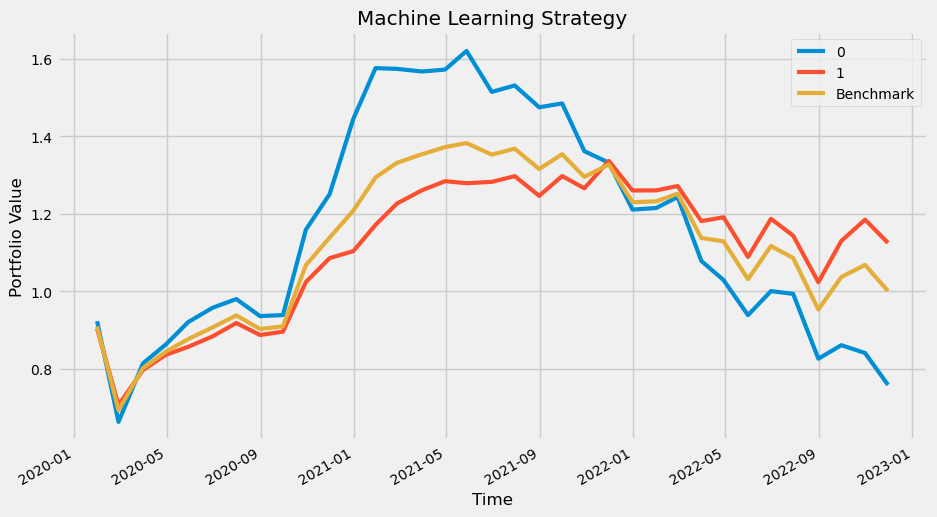

In [16]:
port_values = ret.cumsum().apply(np.exp)

port_values_graph = port_values[[0, 1, 'Benchmark']].plot(figsize=(10,6),
                                      title='Machine Learning Strategy', 
                                      ylabel='Portfolio Value', 
                                      xlabel='Time')
plt.savefig('Machine Learning Strategy.png')

_____________________________________________________________________________________________________________________

# 3. Economic Interpretation

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# 4. Optimization

**Step 1: Train different algorithms with various depth levels, observe their out-of-sample performance for  K-fold cross-validtion**

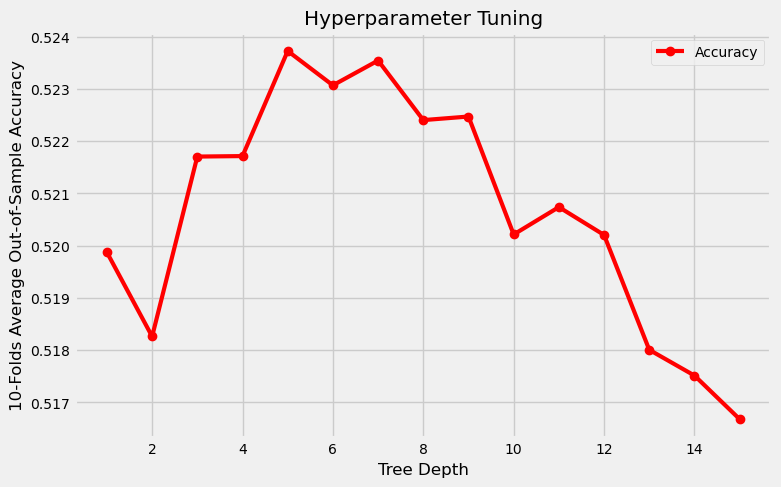

In [17]:
# we create an empty list to store the results
optimal_stat=[]

# we start the loop
for depth in range(1,16):

    # we instantiate the classifier
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    
    # we run the 10-fold cross validation on the train set only
    kscores = cross_val_score(clf, X_train, y_train, cv=10)       
        
    # we save the average accuracy (and the number of eighbors)
    optimal_stat.append([depth, kscores.mean()])

# we transform the results into a DataFrame
optimal_stat = pd.DataFrame(optimal_stat, columns=['Tree Depth', 'Accuracy']).set_index('Tree Depth')

# we plot
optimal_stat.plot(figsize=(8,5), 
             style='r-o',
             xlabel='Tree Depth',
             ylabel='10-Folds Average Out-of-Sample Accuracy',
             title='Hyperparameter Tuning')

plt.savefig('Hyperparameter Tuning for 10-Folds Average Out-of-Sample Accuracy')

Determine the optimal depth

In [18]:
opt_stat_depth = optimal_stat['Accuracy'].idxmax()
opt_stat_depth

5

Now the variable opt_depth contains the optimal depth level and we can pass this to our trees.



In [19]:
# We instantiate the tree with the optimal depth and train it
clf_opt = tree.DecisionTreeClassifier(max_depth=opt_stat_depth)
clf_opt.fit(X_train, y_train)

# We build our out-of-sample predictions
y_test_pred = clf_opt.predict(X_test)

# We can measure the out-of-sample accuracy
os_accuracy = metrics.accuracy_score(y_test, y_test_pred)
print(f'Out-of-Sample Accuracy:, {round(os_accuracy, 3)}')

# We can measure the out-of-sample simulated investment performance
os_pred = pd.Series(y_test_pred.astype('int64'), index = X_test.index).rename('Winner')
ret, dia = ap.ml_analysis(os_pred, prices)
dia

Out-of-Sample Accuracy:, 0.521


,0,1,Benchmark,Active,Neutral
Mean Return,-0.100888,0.036709,0.000162,0.036547,0.137597
St. Dev.,0.360523,0.251008,0.276565,0.054797,0.178716
RR Ratio,-0.279838,0.146248,0.000587,0.666956,0.769922
% Positive,0.514286,0.600000,0.628571,0.600000,0.600000
Worst Month,-0.333506,-0.245283,-0.271365,-0.041325,-0.127214
Best Month,0.215294,0.132948,0.160397,0.029106,0.088222
Max DrawDown,-0.617402,-0.267175,-0.351337,-0.120509,-0.378475


There is a **negative, and slight decrease** in the risk-adjusted performance of our strategy. The RR ratio of the predicted Winner ('1') decreased from 15.98% to 14.62%


In [20]:
# We instantiate the tree with the optimal depth and train it
clf_opt = tree.DecisionTreeClassifier(max_depth=7)
clf_opt.fit(X_train, y_train)

# We build our out-of-sample predictions
y_test_pred = clf_opt.predict(X_test)

# We can measure the out-of-sample accuracy
os_accuracy = metrics.accuracy_score(y_test, y_test_pred)
print(f'Out-of-Sample Accuracy:, {round(os_accuracy, 3)}')

# We can measure the out-of-sample simulated investment performance
os_pred = pd.Series(y_test_pred.astype('int64'), index = X_test.index).rename('Winner')
ret, dia = ap.ml_analysis(os_pred, prices)
dia

Out-of-Sample Accuracy:, 0.52


,0,1,Benchmark,Active,Neutral
Mean Return,-0.098891,0.041594,0.000162,0.041432,0.140485
St. Dev.,0.349120,0.250194,0.276565,0.054059,0.161980
RR Ratio,-0.283256,0.166248,0.000587,0.766424,0.867299
% Positive,0.514286,0.600000,0.628571,0.657143,0.657143
Worst Month,-0.334004,-0.241691,-0.271365,-0.040385,-0.114472
Best Month,0.203728,0.135371,0.160397,0.029674,0.092313
Max DrawDown,-0.597874,-0.259246,-0.351337,-0.120765,-0.344525


**Step 3: Hyperparameter Tuning for Information Ratio of Predicted Winner**

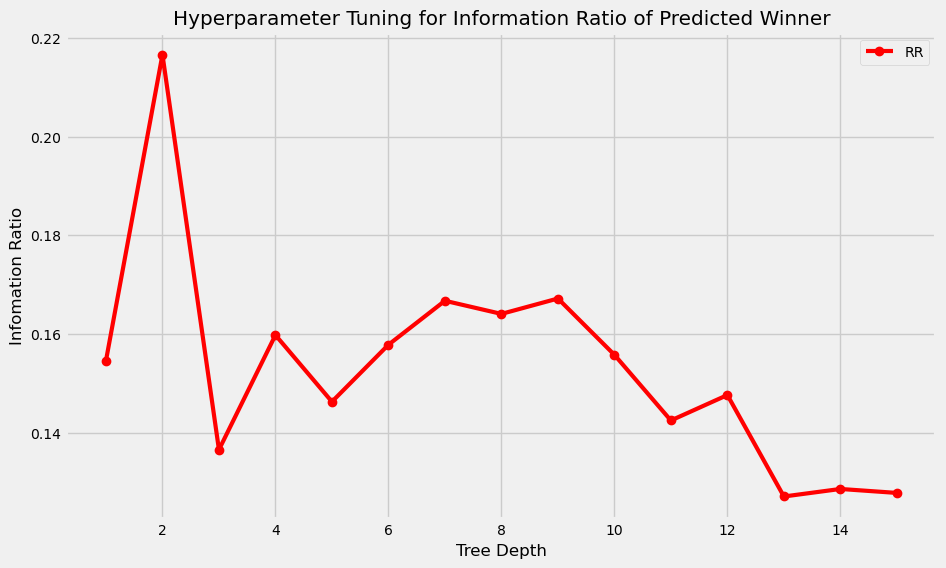

In [21]:
# we create an empty list to store the results
optimal_depth_rr=[]

# we start the loop
for depth in range(1,16):

    # we instantiate the classifier
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    
    # We fit the model using the training data
    clf.fit(X_train, y_train)

    # Out-of-sample predictions
    y_test_pred = clf.predict(X_test)
    
    # We can measure the out-of-sample simulated investment performance
    os_pred = pd.Series(y_test_pred.astype('int64'), index = X_test.index).rename('Winner')
    ret, dia = ap.ml_analysis(os_pred, prices)
    rr = dia.iloc[2,1]    
    
    # we save the average accuracy (and the number of eighbors)
    optimal_depth_rr.append([depth, rr])


# we transform the results into a DataFrame
optimal_depth_rr = pd.DataFrame(optimal_depth_rr, columns=['Tree Depth', 'RR']).set_index('Tree Depth')
# we plot
optimal_depth_rr.plot(figsize=(10,6), 
             style='r-o',
             xlabel='Tree Depth',
             ylabel='Infomation Ratio',
             title='Hyperparameter Tuning for Information Ratio of Predicted Winner')
plt.savefig('Hyperparameter Tuning for Information Ratio of Predicted Winner')

In [22]:
optimal_depth_rr

,RR
Tree Depth,
1,0.154569
2,0.216606
3,0.136518
4,0.159762
5,0.146248
6,0.157798
7,0.166715
8,0.164052
9,0.167172


## 4.1 Managing Overfitting

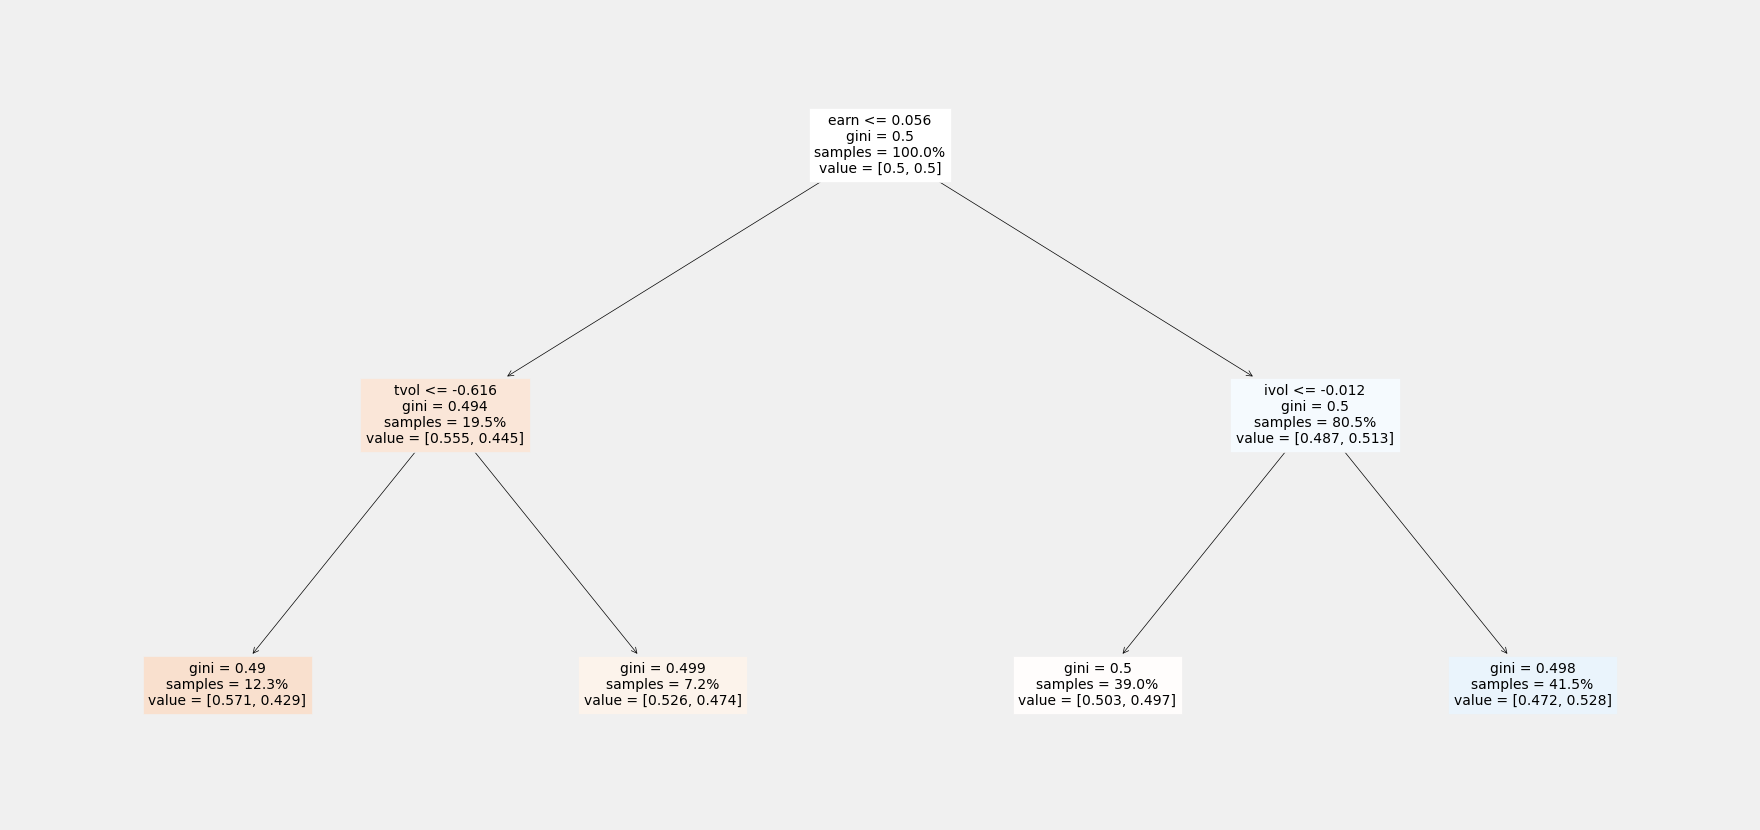

In [23]:
clf_large = tree.DecisionTreeClassifier(max_depth=2)

# We fit the model using the training data
clf_large.fit(X_train, y_train)
plt.figure(figsize=(20,10))
tree.plot_tree(clf_large, fontsize=10, feature_names = X.columns, filled=True, proportion=True)
plt.savefig('decision_tree_depth=2.png')

In-Sample Accuracy: 0.528
Out-of-Sample Accuracy:, 0.525
10-Folds Cross Validation Average Accuracy:, 0.523


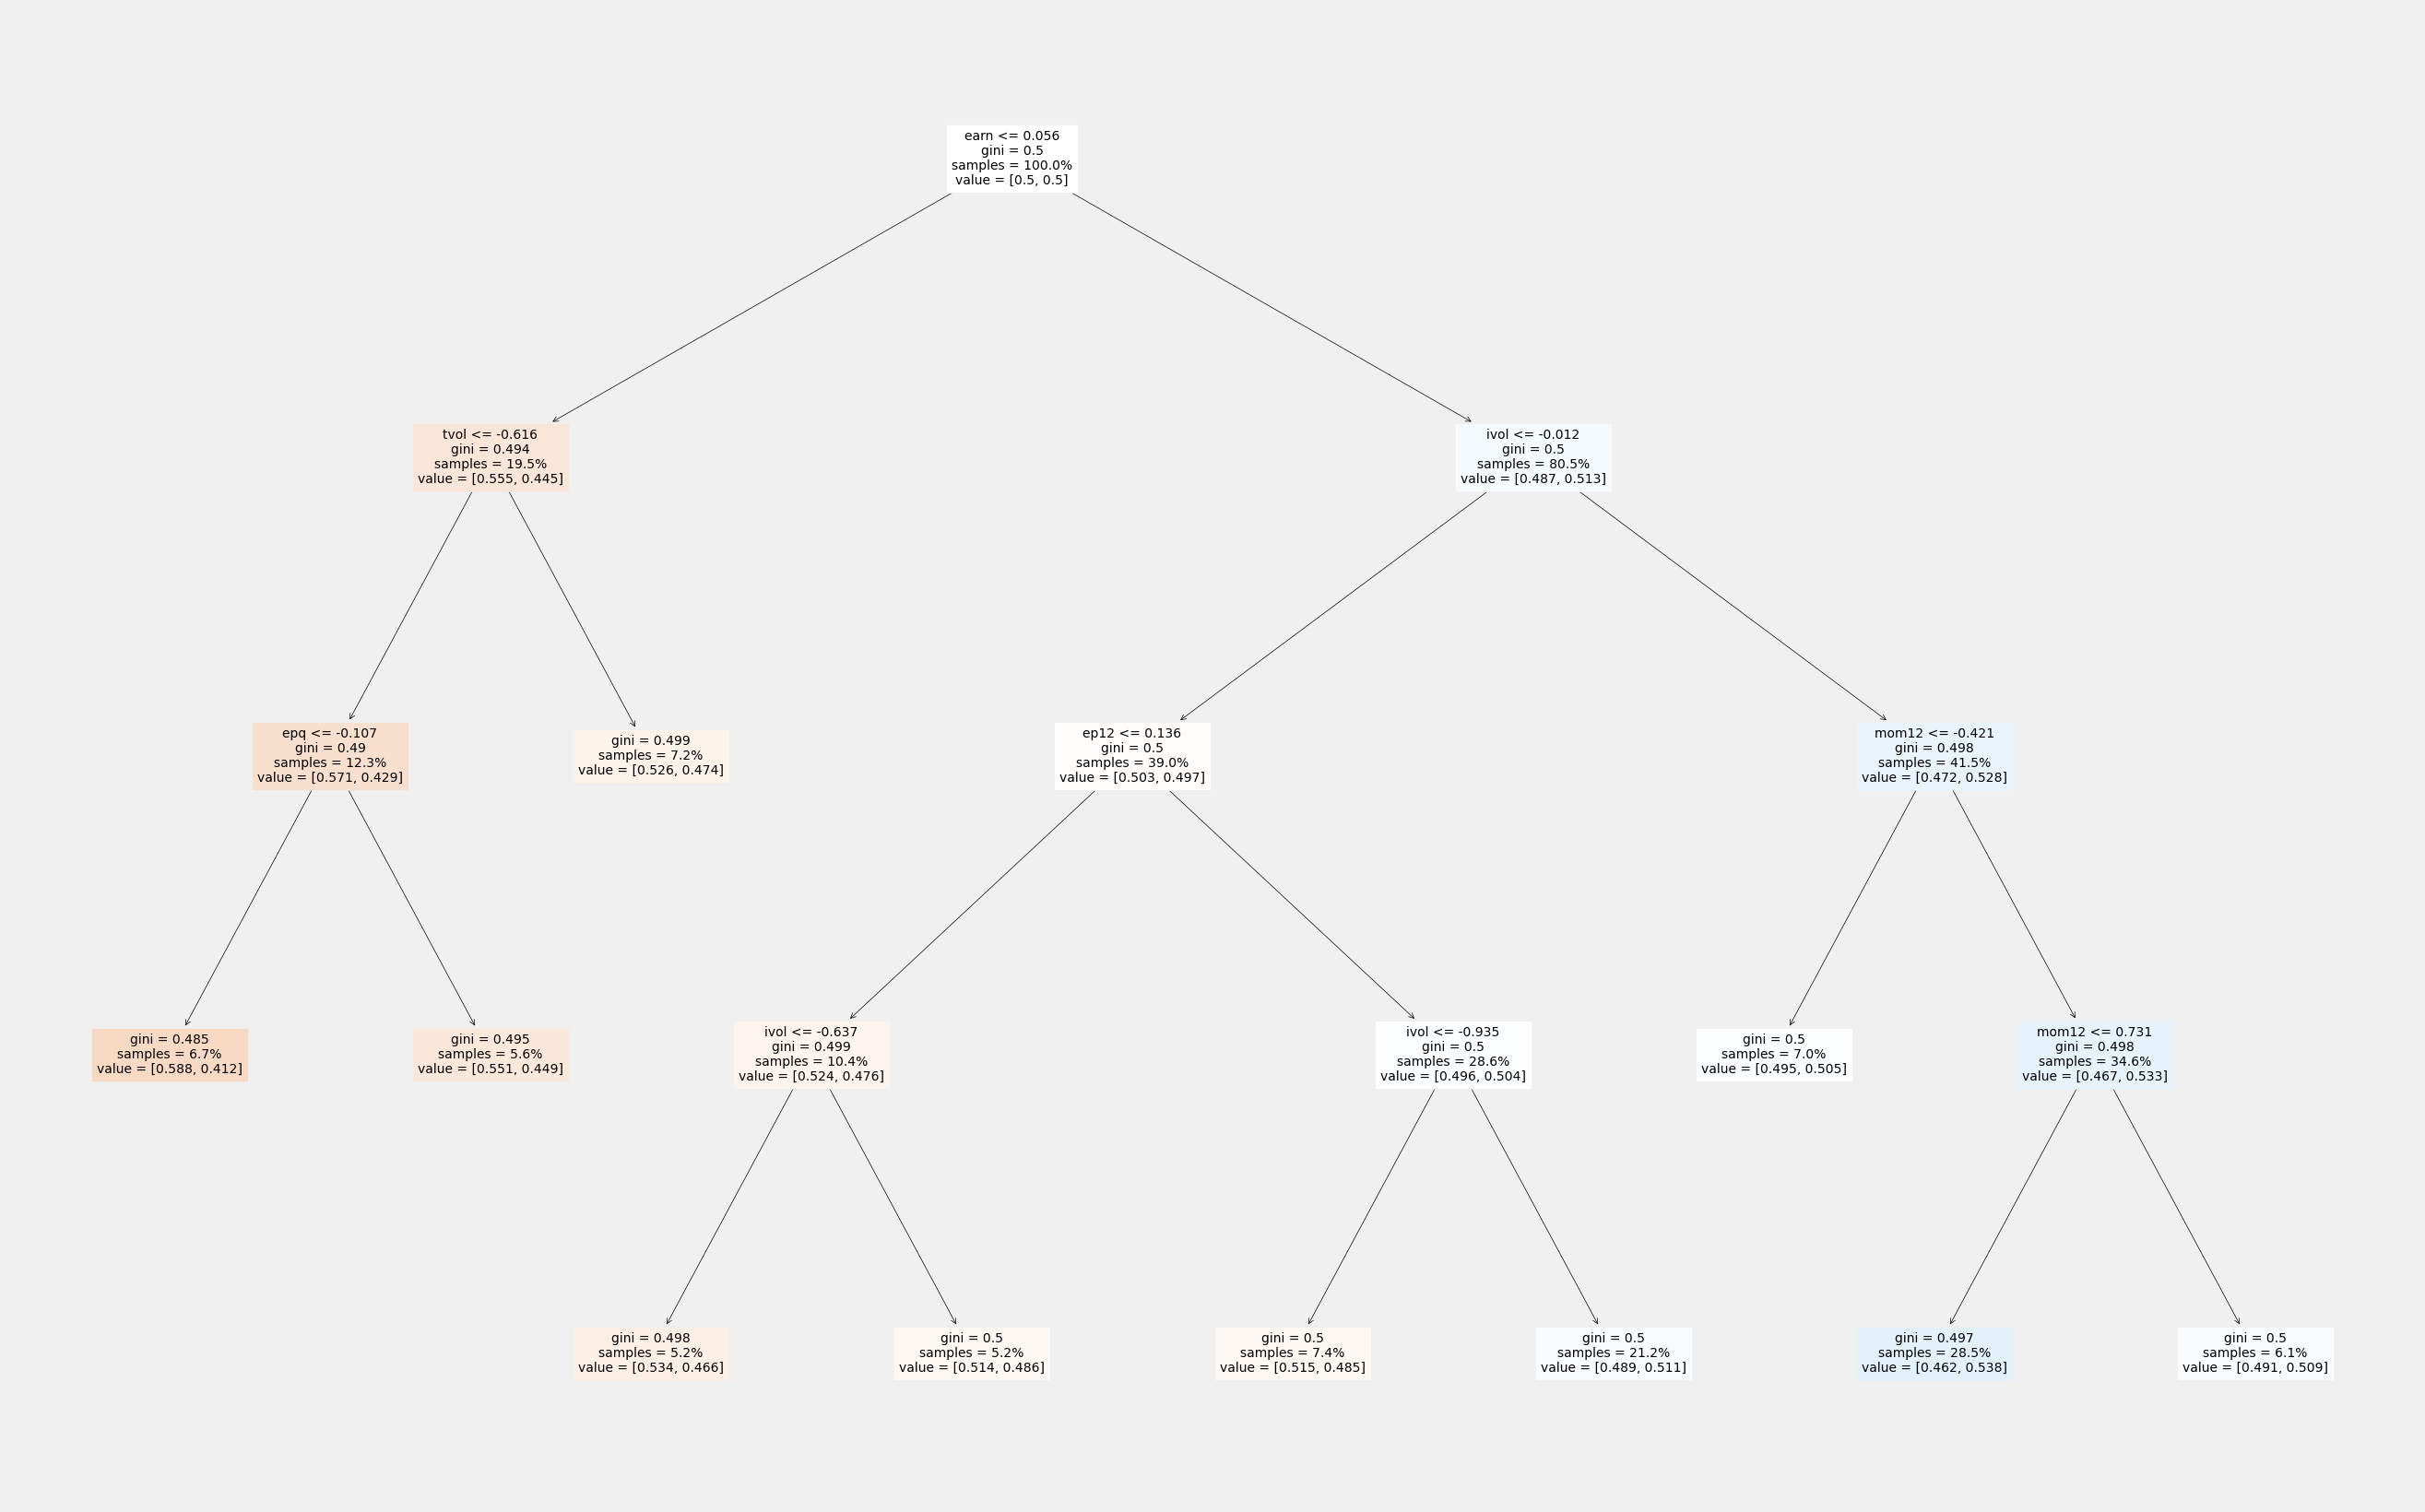

In [24]:
clf_leaf = tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.05)

clf_leaf.fit(X_train, y_train)
plt.figure(figsize=(30,20))
tree.plot_tree(clf_leaf, fontsize=10, feature_names = X.columns, filled=True, proportion=True)
plt.savefig('decision_tree_leaf.png')

# We form the prediction
y_train_pred = clf_leaf.predict(X_train)
y_test_pred = clf_leaf.predict(X_test)

# We measure the accuracy
is_accuracy = metrics.accuracy_score(y_train, y_train_pred)
os_accuracy = metrics.accuracy_score(y_test, y_test_pred)

# We format and print the results
print(f'In-Sample Accuracy: {round(is_accuracy, 3)}') # The round function is to format the number
print(f'Out-of-Sample Accuracy:, {round(os_accuracy, 3)}')

scores = cross_val_score(clf_leaf, X, y, cv=10)
print(f'10-Folds Cross Validation Average Accuracy:, {round(scores.mean(), 3)}')

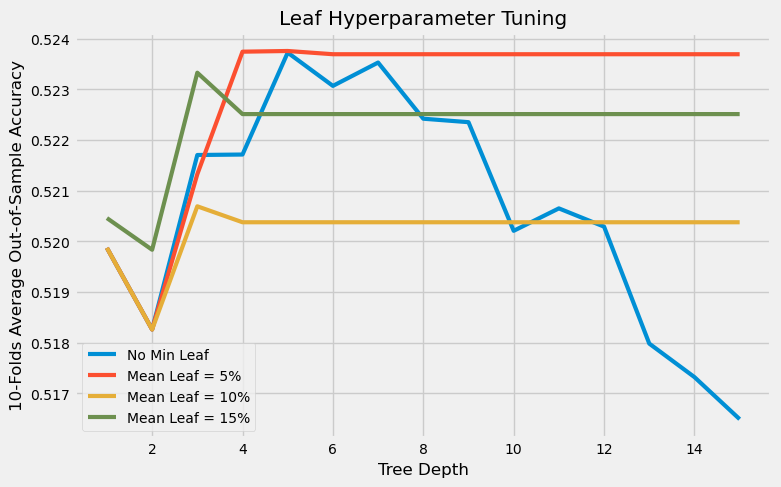

In [25]:
# we create an empty list to store the results
optimal_leaf=[]

# we start the loop
for depth in range(1,16):

    # we instantiate the classifier
    clf1 = tree.DecisionTreeClassifier(max_depth=depth)
    clf2 = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=0.05)
    clf3 = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=0.10)
    clf4 = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=0.15)

    
    # we run the 10-fold cross validation on the train set only
    kscores1 = cross_val_score(clf1, X_train, y_train, cv=10) 
    kscores2 = cross_val_score(clf2, X_train, y_train, cv=10)
    kscores3 = cross_val_score(clf3, X_train, y_train, cv=10)
    kscores4 = cross_val_score(clf4, X_train, y_train, cv=10)
    
    # we save the average accuracy (and the number of eighbors)
    optimal_leaf.append([depth, kscores1.mean(), kscores2.mean(),kscores3.mean(), kscores4.mean()])


# we transform the results into a DataFrame
optimal_leaf = pd.DataFrame(optimal_leaf, columns=['Tree Depth', 'No Min Leaf', 'Mean Leaf = 5%', 'Mean Leaf = 10%', 'Mean Leaf = 15%']).set_index('Tree Depth')

# we plot and export the picture
optimal_leaf.plot(figsize=(8,5), 
             xlabel='Tree Depth',
             ylabel='10-Folds Average Out-of-Sample Accuracy',
             title='Leaf Hyperparameter Tuning')

plt.savefig('Leaf_Hyperparameter_Tuning.png')

_____________________________________________________________________________________________________________________

# 5. Regression Tree

_____________________________________________________________________________________________________________________